In [1]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('figure', figsize=(15, 5))
seed = 123

# Introduction

This practical assignment consists in implementing a simplified version of the KernelPCA class of `sklearn`.

This class will contain three public methods: `fit()`, `transform()` and `fit_transform()`.

# Implementation of KPCA

## Requirements

The objective of this assignment is to complete the class `KPCA` sketched below, which should contain at least the following methods.

---
```python
__init__(self, n_components, kernel, gamma)
```
* This is the construction method for the class, with the following parameters:
    * `n_components`: Reduced dimension.
    * `kernel`: `'linear'` or `'rbf'`.
    * `gamma`: Kernel parameter $\gamma$ of the RBF kernel.
* This method should only store the parameters in fields of the class, to be used when needed.

---
```python
fit(self, X)
```
* This is the training method, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* This method should compute the projecting direction, storing the useful information in fields of the class.

---
```python
transform(self, X)
```
* This is the method that computes the projection, with the following parameters:
    * `X`: New data matrix $\mathbf{X}$.
* This method will used the stored information in the class for projecting new points.
---
```python
fit_transform(self, X)
```
* This method firstly fit the model, and latter apply it over the training data, with the following parameters:
    * `X`: Training data matrix $\mathbf{X}$.
* **NOTE**: This method can be implemented just calling the methods `fit` and `transform`; but also it can be computed more efficiently by theoretically computing the projection in this case. If this second approach is chosen, a brief explanation of why the implemented code is working will be required.

### Some recommendations:

* We will not pay attention to the dataset size when solving the eigenvector problem, the examples used will be simple ones. We recommend the use of `eigs` from `scipy` that computes only the first `k` eigenvalues and eigenvectors. It will be necessary to ensure that the eigenvectors are ordered in terms of the largest eigenvalues.
* The projection direction should be deterministic, so the eigenvectors finded should be flipped in terms of their sign to obtain always the same result.
* Data should be centered inside the method (so the data has zero mean, but the std remains the same), being careful to also center the new data points.
* Remember that the projection direction should have norm 1. This means that during the training the computed eigenvectors should be properly normalized and stored once normalized.

## Implementation

<div class="qst">

* Complete the `KPCA` class below, satisfying the described requirements.

</div>

## Explicación teórica del algoritmo 

Dado un conjunto de $n$ datos de dimensión $d$, expresado matricialmente como $X \in \R^{n \times d}$ se pretende reducir su dimensionalidad  a $p < d$  resultando $\hat X \in \R^{n \times p}$ con la restricción de maximizar la varianza de los datos resultantes. 

- Para ello se realizará una transformación  $\phi$ de los datos. 
- Para después realizar una proyección de los datos $V \phi(X)$.
Supondremos que $\bar{\phi(X)} = 0$ 

Con una notación de vector por filas y bajo hipótesis de que $\phi(X)$ se encuentra centrado, la varianza de los dados proyectados en una dimensión vendrá dada por 
$$Var(u \phi(X)^T) = \frac{1}{N} u \phi(x_i) \phi(x_i)^T u^T.$$


Podemos expresar el problema como uno de optimización: 
donde $u$ será el vector que determina la proyección a una dimensión. Imponemos  que sea de norma uno para evitar. 

$$\max_{u} Var(u \phi(X)^T) + \lambda (1 - u u^T)$$

$$
\max_{u} \frac{1}{N} u \phi(x_i) \phi(x_i)^T u^T + \lambda (1 - u u^T) \tag{1}
$$

Derivando con respecto a $u$ e igualando a 0, tenemos que se alcanza un extremo en: 

$$
\frac{1}{N} u \phi(x_i) \phi(x_i)^T = \lambda u \tag{2}
$$

Como $\lambda \in \mathbb{R}^+$ necesariamente se trata de un máximo y además $u$ será combinación lineal de las filas de $\phi(X)$:

$$
u
= 
\sum_{j=1}^n \alpha_j \phi(x_j)
\tag{3}
$$

Sustituyendo en (3) en (2)

$$
\frac{1}{N} 
\left( 
    \sum_{j=1}^n \alpha_j \phi(x_j)
\right)
\phi(x_i) \phi(x_i)^T  
= \lambda \sum_{j=1}^n \alpha_j \phi(x_j) 
\tag{4}
$$

Por comodidad en los cálculos utilizaremos la matriz de kernel $K(X)$ donde cada componente viene dada por
$$
K(x_i,x_j) = \phi(x_i)  \phi(x_j)^T.
$$

Multiplicando por $\phi^T(x_l)$, utilizando la definición recién dada y  reescribiendo en forma matricial 
llegamos a que 

$$
\sum_{i=0}^n K(x_i, x_l) 
\sum_{j=1}^n \alpha_j K(x_i, x_j)
= 
\lambda \frac{1}{N}
\sum_{i=0}^n \alpha_j  K(x_i, x_l) 
$$

$$
K K \alpha^T = n \lambda K \alpha. 
$$

$K$ es simétrica, semidefinida positiva y tiene inversa por lo que 

$$
K \alpha^T = n \lambda \alpha
\tag{5}
$$
Como $\lambda$ es una constante positiva cualquiera, tan general es la igualdad anterior (5) como (6)
$$
K \alpha^T = \lambda \alpha
\tag{6}
$$

Por lo tanto (6) tendrá solución en $\lambda$ valor propio de $K$ cuyo vector propio asociado es $\alpha$. 

Por la restricción de norma uno del vector, concluimos que 

$$
u = \frac{a}{\sqrt{\lambda}}
\tag{7}
$$

Como queremos maximizar la varianza para $p$ componentes bastará con tomar los vectores propios normalizados asociados a los $p$ valores propios más grandes. 

## ¿Y si $\phi$ no está centrada?  

Habría que transformar la $\phi$ para que lo esté. Como nosotros trabajamos con la matriz de kernel deberemos centrar cada uno de sus componentes, esto se hará con la función `kernelCentered` (8) cuya documentación puede encontrar en [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KernelCenterer.html) (consultada por última vez el 1 de diciembre de 2022) y cuyos fundamentos teóricos puede encontrar en el artículo: 

1. Schölkopf, Bernhard, Alexander Smola, and Klaus-Robert Müller. “Nonlinear component analysis as a kernel eigenvalue problem.” Neural computation 10.5 (1998): 1299-1319.


## Cálculo de las proyecciones   

Para calcular las proyecciones  $i-$ésima con $i \leq p$ basta con hacer uso del vector propio normalizado $i$-ésimo: 

$$
y_i = v_i \tilde{\phi}(x_{\text{new}}) = v_i \tilde{K}(X_{\text{fit}}, x_{\text{new}})
\tag{9}
$$
donde a tilde representa que ya están centrados y $X_{\text{fit}}$ son los datos que se utilizaron para determinar los vectores propios. 

## Cálculo de la proyección de $X_{\text{fit}}$

Una implementación optimizada del método `fit_transform` consiste en notar que si 
$$
x_{\text{new}} = X_{\text{fit}}
$$
entonces la proyección a calcular vendrá dada por (6), es decir 

$$
y_i 
=
\lambda \alpha. 
\tag{10} 
$$

## Otras consideraciones sobre la implementación 

1. Tanto $X_{\text{fit}}$ como $X_{\text{new}}$ deben de escribirse matricialmente (como listas de listas de la misma dimensión). 
2. Comportamiento determinista (11):

Se ha programado con un comportamiento determinista que sea exactamente igual que el implementado en las bibliotecas de 
*sklearn* para ello la dirección de cada vector propio vendrá dada con el siguiente algoritmo: 
i. Determinación de la componente con mayor magnitud en valor absoluto. 
ii. Se multiplica el vector por el signo de la componente anterior. 

Este comportamiento se implementa en el método `_flip`.

3. Se ha diseñado para que la dimensión de proyección pueda ser cualquiera (menos que la original) aunque a priori en el ejercicio particular solo se pedía una dimensión. 

4. La bibliotecas numéricas que calculan los valores propios trabajan con números complejos, por las observación de la naturaleza de la matriz de kernel durante su desarrollo teórico sabemos que toman valores reales, así que nos quedaremos directamente con la parte real de los vectores y valores propios obtenidos (12). 


  





(90, 2)


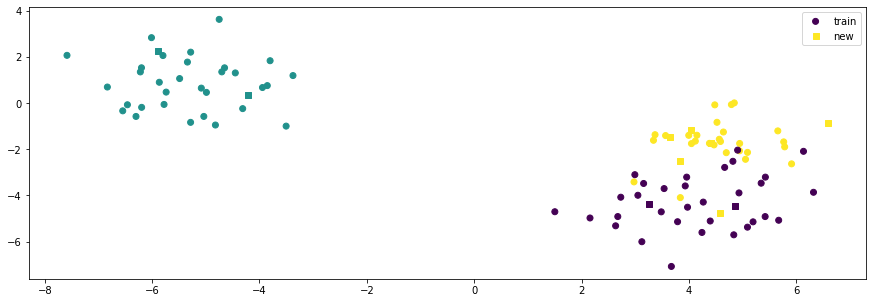

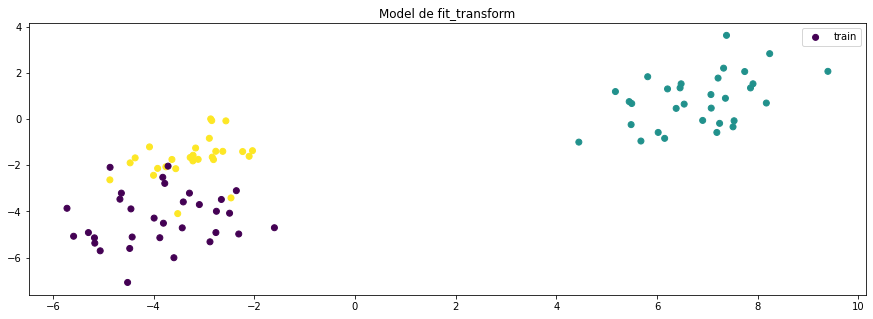

In [2]:
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from sklearn.preprocessing import KernelCenterer
from scipy.sparse.linalg import eigs

class KPCA():
    """
        Kernel PCA.
    """
    def __init__(self, n_components, kernel, gamma=None):
        '''
        Configuración de los valores iniciales para el método de reducción de dimensionalidad Kernel PCA
        Parámetros: 
        - `n_component`: número de componentes. 
        - `kernel`: string o function, si es un string debe de ser `linear` o `rbf`
        - `gamma : float `: Hiperparámetro del método de Kernel PCA 
        '''
        # Assignment of the hyper-parameters (complete).
        
        self.n_components = n_components # Dimensión a reducir 
        self.kernel = kernel

        # Comprobaciones del gamma 
        if gamma != None and not (isinstance(gamma, float) or isinstance(gamma, int)) :
            raise AttributeError(f'Not valid gamma type, should be an integer or float but {type(gamma)} found')
        if (isinstance(gamma, float) or isinstance(gamma, int)) and gamma < 0: 
            raise AttributeError(f'Not valid gamma value, should be positive but {gamma} found')
        
        # Asignamos una función adicional
        if self.kernel == 'rbf':
            self.kernel_function= lambda X, Y : rbf_kernel(X, Y, gamma)
        elif self.kernel == 'linear':
            self.kernel_function = lambda X, Y: linear_kernel(X, Y)
        elif callable(kernel): # Permitimos que además se le pueda añadir una función adicional
            self.kernel_function = kernel
        else:
            raise AttributeError(f'Not valid kernel type: {self.kernel}')

        
    def fit(self, X):
        '''Determina los vectores propios normalizados necesarios para la proyección. 
        Parámetros: 
        - `X` es una matriz con los datos con los qe se van a sacar los valores. 
        '''
        self.X_fit = X
        # Sacamos el kernel y lo centramos (ver desarrollo teórico (8))
        K = np.array(self.kernel_function(X, X))
        self.transformer = KernelCenterer().fit(K)
        centered_kernel_matrix= self.transformer.transform(K) 
        # Cálculo de los vectores y valores ver (6)
        valores_propios , vectores_propios = eigs(centered_kernel_matrix, self.n_components)
        self.vectores_propios = vectores_propios.real.T # Motivación en (12)
        # Selección de la orientación determinista explicada en (11)
        vectores_propios = list(map(self._flip, self.vectores_propios)) 
        self.valores_propios = valores_propios.real.T # Motivación en (12)
        valor_vector = list(zip(valores_propios.real, self.vectores_propios))
        # Ordenamos los valores propios de mayor a menor (Obsevación tras (7))
        valor_vector.sort(key = lambda k: k[0], reverse = True) 
        # Escalar la a (ver (7))
        self.a_escalada = np.array(list( map( lambda k: k[1]/ np.sqrt(k[0]), valor_vector) ))
        
        return self

    def transform(self, X):
        '''Calcula la proyección de X
        Es necesario realizar previamente un fit
        '''
        try:
             self.X_fit
        except:
            raise Exception("Fit should be done first")

        # Computation of the projected components.
        # Desarrollo teórico en (9) 
        kernel_matrix = self.kernel_function(X, self.X_fit) # Kernel sin centrar
        kernel_matrix = self.transformer.transform(kernel_matrix) # central kernel
        return self.a_escalada @ kernel_matrix.T

    def fit_transform(self, X ):
        '''Realiza un fit y un transform de los datos de manera optimizada
        El fundamento teórico se explica en (10)
        '''
        self.fit(X)
        # Sin normalizar 
        #return self.valores_propios @ self.vectores_propios
        return np.multiply(self.a_escalada.T, self.valores_propios)
        


    def _flip(self, v):
        ''' Ajusta el signo determinista del vector propio (motivado en (11)).
        Memoria: Tras consultar el comportamiento determinista de sklearn, determina la dirección 
        del vector a partir del coeficiente mayor, la documentación dice así: 
        
        Sign correction to ensure deterministic output from SVD.
        Adjusts the columns of u and the rows of v such that the loadings in the
        columns in u that are largest in absolute value are always positive.

        '''
        max_abs_rows = np.argmax(np.abs(v))
        signs = np.sign(v[max_abs_rows])
        v *= signs
        return v

# Borrar
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]
print(X_train.shape)
n_components = 1
model_my = KPCA(n_components=n_components, kernel='linear')
plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

def muestraSimple(Xx,Xy, Y, title):
    plt.scatter(Xx, Xy,c=Y, label='train')
    plt.title(title)
    plt.legend()
    plt.show()
muestraSimple(model_my.fit_transform(X_train), X_train[:,1],y_train,'Model de fit_transform')


## Comparative with *scikit-learn*

The following cell generates the *blobs* dataset and depicts it.

(90, 2)


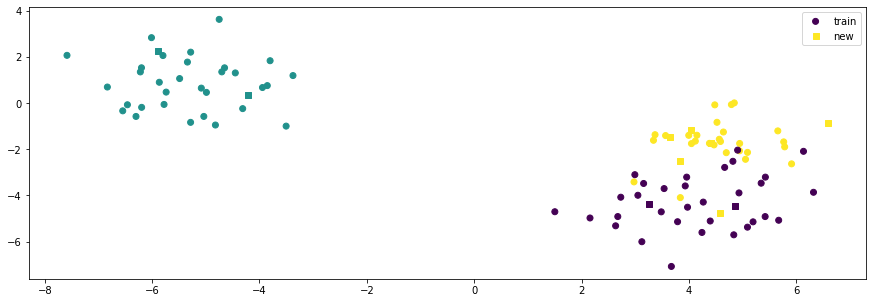

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(random_state=seed)
X_train = X[:90,:]; y_train=y[:90]
X_new = X[90:,:]; y_new=y[90:]
print(X_train.shape)


plt.scatter(X_train[:,0], X_train[:,1],c=y_train, label='train')
plt.scatter(X_new[:,0], X_new[:,1], c=y_new, marker='s', label='new')
plt.legend()
plt.show()

def muestraSimple(Xx,Xy, Y, title):
    plt.scatter(Xx, Xy,c=Y, label='train')
    plt.title(title)
    plt.legend()
    plt.show()

<div class="qst">

* Train and transform a classical PCA model over the training data (`X_train`), using both the implemented `KPCA` class using a linear kernel and the `PCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

In [4]:
from sklearn.decomposition import PCA

kernel = 'linear'
n_components=1

model_my = KPCA(n_components=n_components, kernel='linear')
model_sk = PCA(n_components=n_components)

# Apartado 1: Training of the model
model_my.fit(X_train)
model_sk.fit(X_train)

PCA(n_components=1)

## Explicación 

### Apartado 2: Comparative of the eigenvectors 

#### Obtención vector propio para PCA 

De acorde a la documentación oficial de sklearn para PCA [ver](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) consultada por última vez el 22 de noviembre del 2022. 
El atributo `components_` devuelve: 
```
components_ndarray of shape (n_components, n_features)
Principal axes in feature space, representing the directions of maximum variance in the data. Equivalently, the right singular vectors of the centered input data, parallel to its eigenvectors. The components are sorted by explained_variance_.
```

Es decir PCA calcula $ X = U D_X V^T$ y devuelve el vector propio $v_1$ asociado al mayor valor propio. Esto tiene la ventaja de que permite decir la dirección en que la varianza es máxima. 

En nuestro caso,calculamos la matriz de covarianza $\Sigma$
$\Sigma =  U D_\Sigma V^T$. 

Como resultado de esto se verá que difieren en tamaño, que es lo que procedemos a mostrar en el código de ejemplo. 



In [5]:
# Apartado 2: Comparative of the eigenvectors.
print('Vectores propios es sklearn')
print(model_sk.components_)
print('Dimensiones de los vector propio de nuestro método')
print(model_my.a_escalada.shape)
print(model_my.a_escalada)

Vectores propios es sklearn
[[-0.92260084  0.38575601]]
Dimensiones de los vector propio de nuestro método
(1, 90)
[[-0.00170185 -0.00144365  0.00315548 -0.00089386 -0.00149731  0.00330584
  -0.00195384 -0.00101385 -0.00112589 -0.00150643  0.00316604 -0.00124488
   0.00412394 -0.00245382  0.00272538  0.00323974 -0.00222184 -0.00108122
  -0.00136759  0.0025524  -0.00135725 -0.00138989 -0.0009797   0.00240797
   0.00310645  0.00323024  0.0028349  -0.00126455  0.00339847 -0.00121293
  -0.00204988 -0.00226901 -0.00157906 -0.00179196 -0.00203722  0.00329657
   0.00310401 -0.00159641 -0.00124917 -0.00213565  0.00264391  0.00227101
   0.00270032 -0.00115289 -0.00123387 -0.00141198 -0.00198297  0.00249343
  -0.00164926  0.00303186  0.00321436  0.00287044  0.00347081 -0.00196091
   0.00241332  0.00317956 -0.00103468  0.00284394 -0.00141369 -0.00121385
  -0.00196446 -0.00167622 -0.0007027   0.00195203 -0.00143732 -0.00213749
  -0.00251145  0.003449   -0.00175177 -0.00172119 -0.00191706 -0.002272

Notemos que las dimensiones de sklearn son $1 \times 2$ uno porque estamos reduciendo a una dimensión y $2$ por el número de características del vector de entradas. 

En nuestro caso $1 \times 90$, donde $1$ es la dimensión a la que reducimos y $90$ el número de vectores del conjunto de entrenamientos. Al calcular la matriz de kernel, esta no es más que la matriz de covarianzas de los datos transformados, luego tendrá una dimensión de $90 \times 90$, de ahí que nuestro vector propio tenga dimensión $90$. 

Otra diferencia es que PCA en el vector propio no se ha aplicado el criterio de dirección, ya que la primera componente que es la mayor es negativa. Esto se debe que PCA la almacena con el signo convenido en el atributo `self.eigenvectors_`, mientras que nosotros lo hacemos directamente en la variable almacenada. 


### Apartado 3: Comparación de las proyecciones  

La comparación se hará de manera visual. 
Nótese que los datos debería de proyectarse en una dimensión, ya que `n_components = 1` pero para visualizarlos mejor se hará en dos, tomando como valor de ordenadas el antiguo.
 Esto no afectará a la visualización de la varianza, ya que deberemos de fijarnos en que las distancias en el eje de coordenada; es más no ayudara a ver que cada punto se aplica correctamente, ya que se podrá identificar por ordenada. 

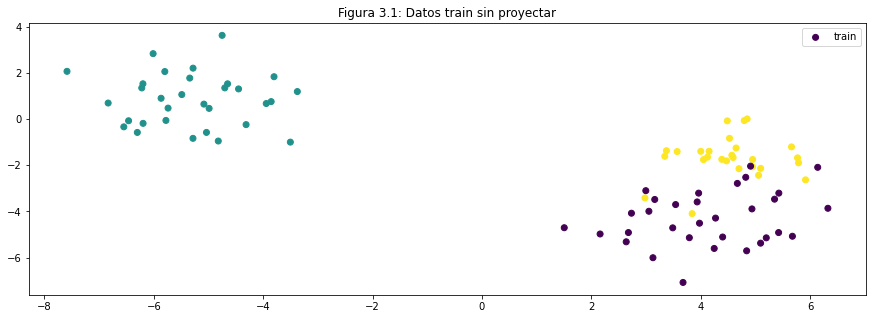

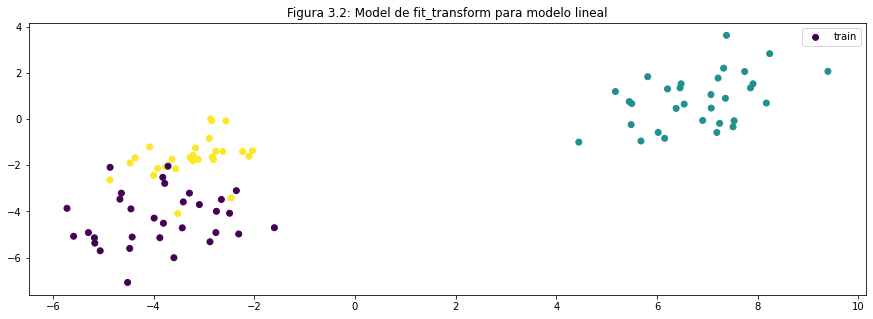

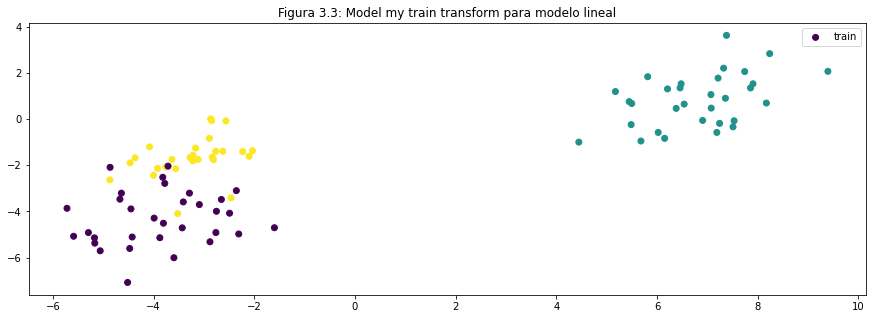

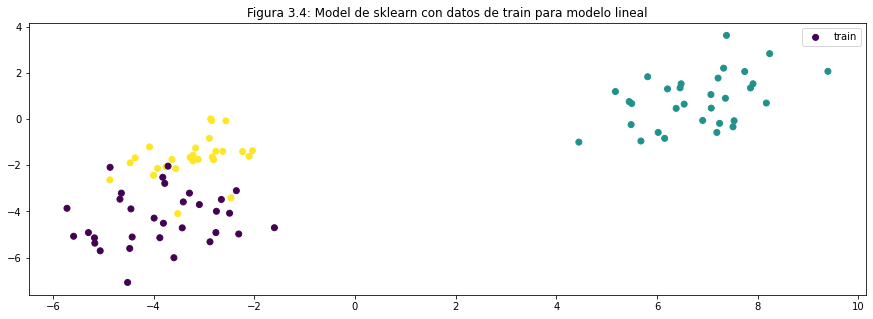

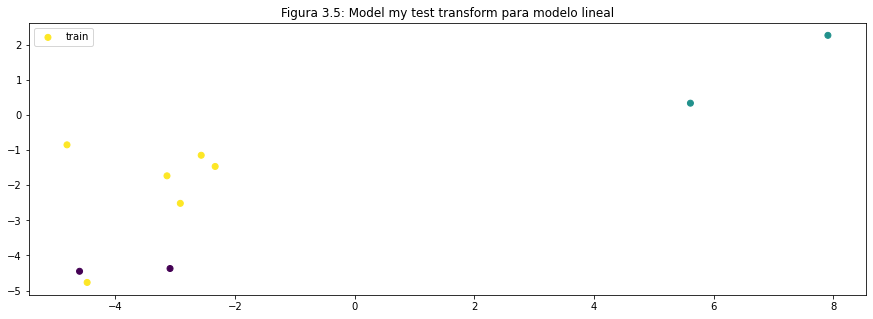

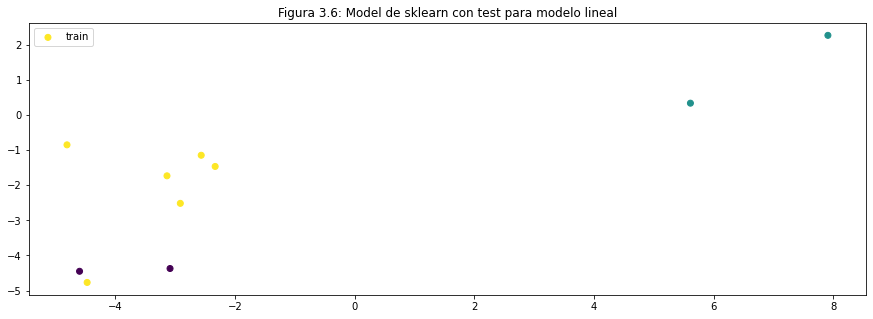

In [6]:
apartado = 3
cnt_figura = 1
tipo_kernel = 'lineal'

muestraSimple(X_train[:,0], X_train[:,1], y_train, f'Figura {apartado}.{cnt_figura}: Datos train sin proyectar')
cnt_figura += 1
muestraSimple(model_my.fit_transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model de fit_transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_my.transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model my train transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_sk.transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model de sklearn con datos de train para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_my.transform(X_new), X_new[:,1],y_new,f'Figura {apartado}.{cnt_figura}: Model my test transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_sk.transform(X_new), X_new[:,1],y_new,f'Figura {apartado}.{cnt_figura}: Model de sklearn con test para modelo {tipo_kernel}')
cnt_figura += 1


### Observaciones sobre los dibujos  

Notemos que para los datos de entrenamiento las `figuras 3.2, 3.3 y 3.4` son idénticas, esto verifica (a nivel práctico) la corrección de la implementación en cuanto a: 
-  Optimización del `fit_transform` (ya que equivale a hacer un fit y luego un transform).
-  Implementación para que el resultado sea determinista (por ser idéntico al de PCA). 

En test también los resultados han sido idénticos, ver figuras `3.5`y `3.6`. 

<div class="qst">

* Train and transform a Kernel PCA model using a RBF kernel over the training data (`X_train`), calling both the implemented `KPCA` class and the `KernelPCA` class of `sklearn`.
* Transform using the previous two models the new data (`X_new`).
* Compare that both classes provide the same outputs (in terms of the eigenvectors and the data projections), describing the obtained results.
</div>

Sklearn tamaño de los componentes (90, 1)
Nuestra implementación, tamaño vector  (90,)
Sklearn tamaño de los componentes [[-0.06836262]
 [ 0.03380803]
 [-0.08755414]
 [ 0.09471101]
 [-0.0065262 ]
 [-0.09804105]
 [-0.00759357]
 [-0.05201932]
 [ 0.04641738]
 [-0.06675903]
 [-0.11273815]
 [ 0.17778204]
 [-0.04361036]
 [-0.04753199]
 [-0.11066928]
 [-0.03941534]
 [-0.05818873]
 [-0.02811017]
 [ 0.19398104]
 [-0.07362361]
 [-0.02945271]
 [ 0.1749856 ]
 [ 0.1176125 ]
 [-0.08654216]
 [-0.12963207]
 [-0.12790533]
 [-0.11788689]
 [-0.05709254]
 [-0.09579103]
 [-0.06054818]
 [ 0.03091052]
 [-0.0579652 ]
 [-0.05182214]
 [ 0.10199366]
 [ 0.05534675]
 [-0.08791072]
 [-0.13259448]
 [ 0.19072941]
 [ 0.04317653]
 [ 0.07229141]
 [-0.09326254]
 [-0.06760298]
 [-0.08512147]
 [ 0.16018923]
 [ 0.17213752]
 [ 0.19491857]
 [-0.03659787]
 [-0.0743319 ]
 [ 0.18544445]
 [-0.11687402]
 [-0.09313601]
 [-0.13123637]
 [-0.10427528]
 [ 0.11287215]
 [-0.09158161]
 [-0.1040165 ]
 [-0.01018775]
 [-0.11182659]
 [ 0.1966

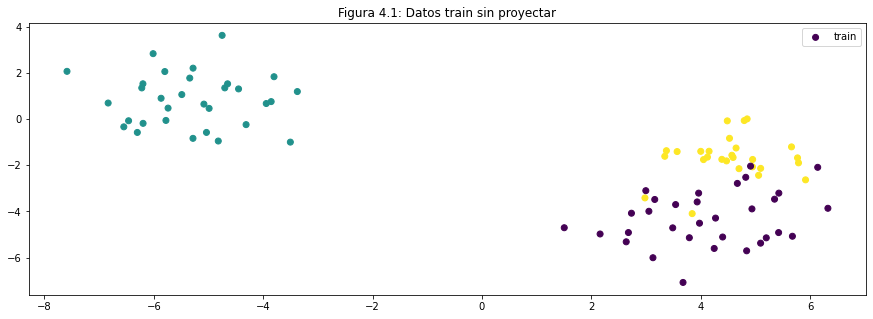

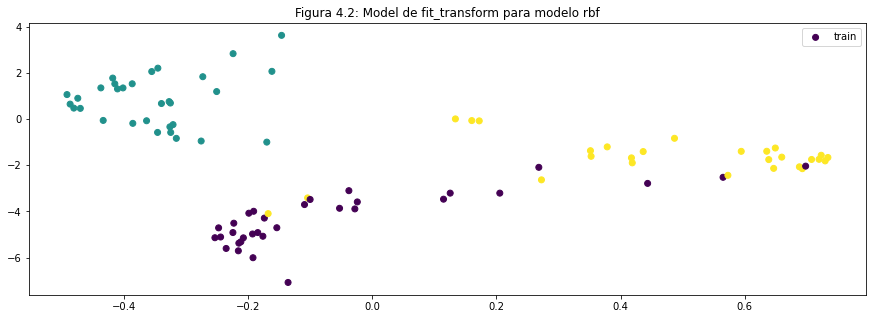

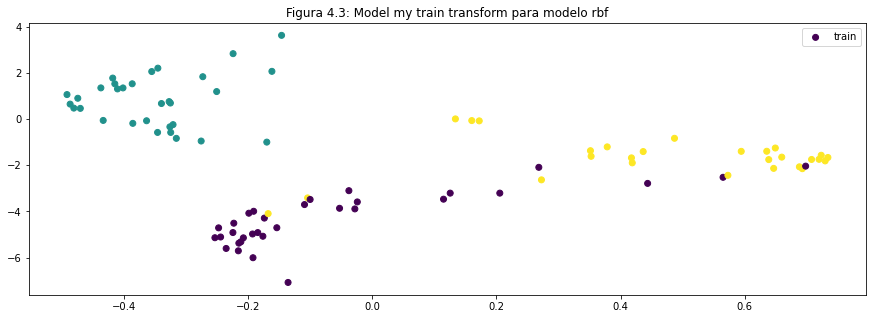

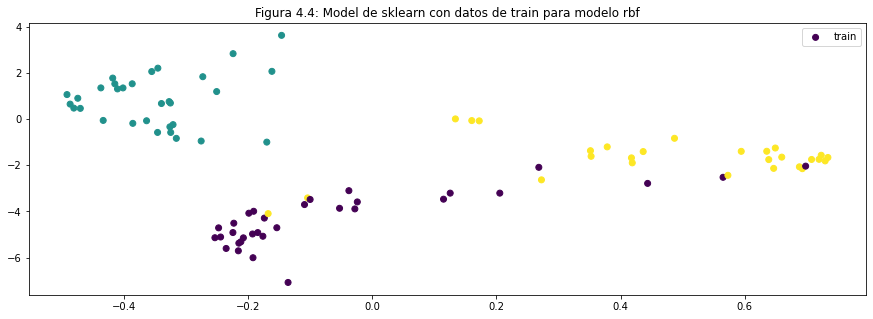

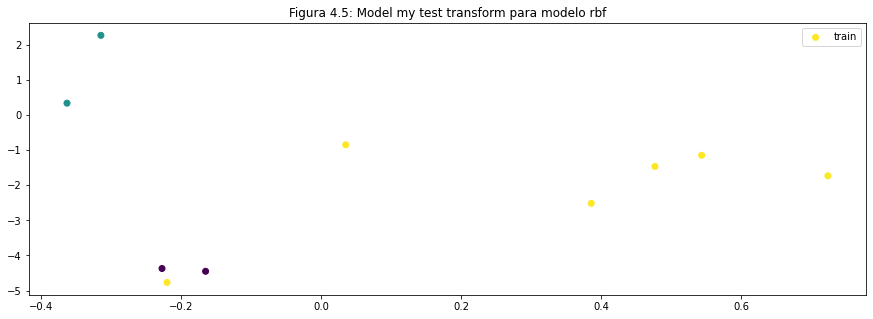

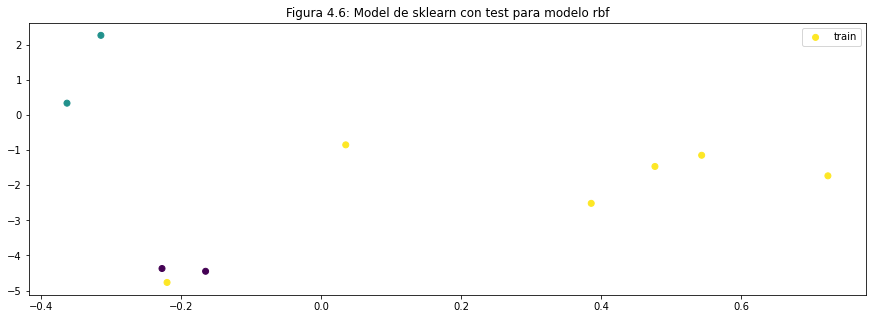

In [7]:
from sklearn.decomposition import KernelPCA

kernel = 'rbf'
n_components=1

# Model definition 
model_my = KPCA(n_components=n_components, kernel='rbf')
model_sk = KernelPCA(kernel=kernel, n_components=n_components)

# Training of the models 
model_my.fit(X_train)
model_sk.fit(X_train)

# Comparative of the eigenvectors (complete).

print('Sklearn tamaño de los componentes',model_sk.eigenvectors_.shape)
print('Nuestra implementación, tamaño vector ',model_my.a_escalada[0].shape)
print('Sklearn tamaño de los componentes',model_sk.eigenvectors_)
print('Nuestra implementación, tamaño vector ',model_my.a_escalada[0])

# Comparative of the projections (complete).
apartado = 4
cnt_figura = 1
tipo_kernel = 'rbf'

muestraSimple(X_train[:,0], X_train[:,1], y_train, f'Figura {apartado}.{cnt_figura}: Datos train sin proyectar')
cnt_figura += 1
muestraSimple(model_my.fit_transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model de fit_transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_my.transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model my train transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_sk.transform(X_train), X_train[:,1],y_train,f'Figura {apartado}.{cnt_figura}: Model de sklearn con datos de train para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_my.transform(X_new), X_new[:,1],y_new,f'Figura {apartado}.{cnt_figura}: Model my test transform para modelo {tipo_kernel}')
cnt_figura += 1
muestraSimple(model_sk.transform(X_new), X_new[:,1],y_new,f'Figura {apartado}.{cnt_figura}: Model de sklearn con test para modelo {tipo_kernel}')
cnt_figura += 1

## Comparing linear kernel against Gaussian kernel

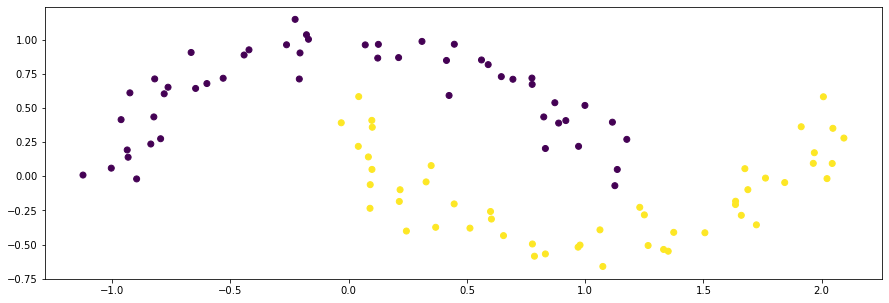

In [8]:
from sklearn.datasets import make_moons

X, y = make_moons(noise=1e-1, random_state=seed)

plt.scatter(X[:,0], X[:,1],c=y)

<div class="qst">

* Using the implemented class `KPCA` compare the result of transforming the above dataset using a linear kernel and an RBF one (looking for an appropriated hyperparameter `gamma` value).
* Is there some model able to properly project the classes separately?
</div>

## Primero vamos a determinar el valor del gamma utilizando una rejilla de búsqueda 

La inspección será visual. 

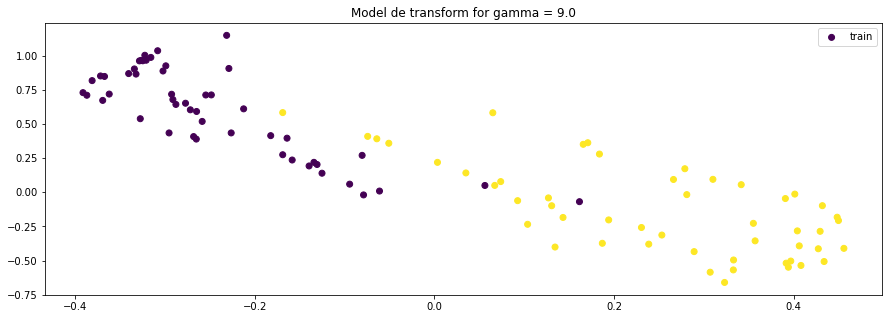

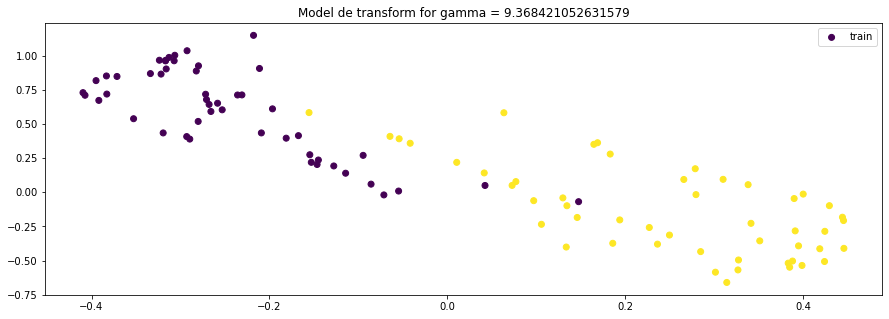

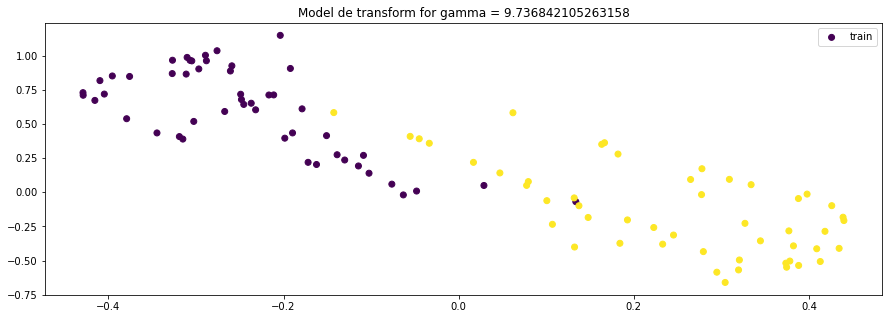

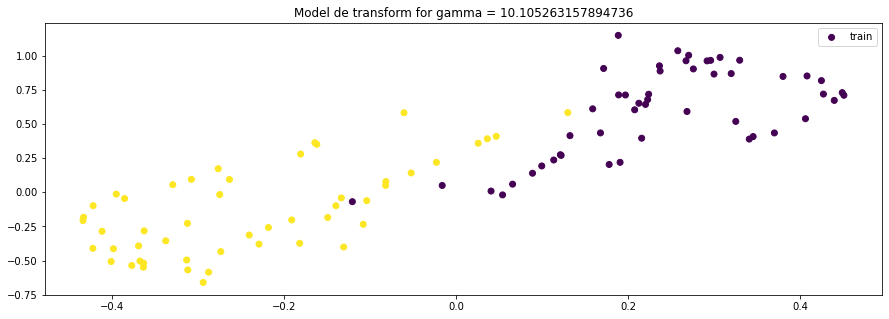

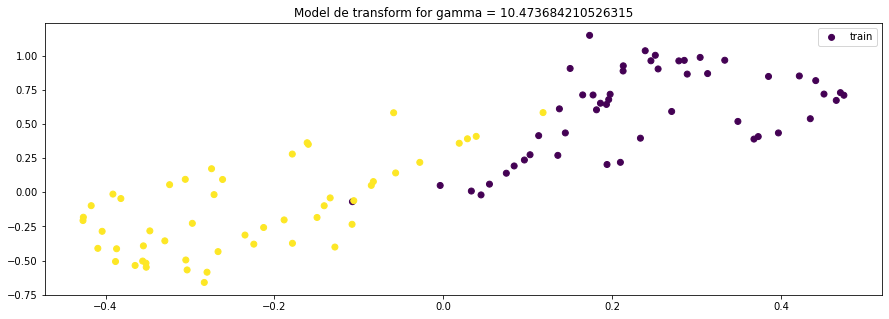

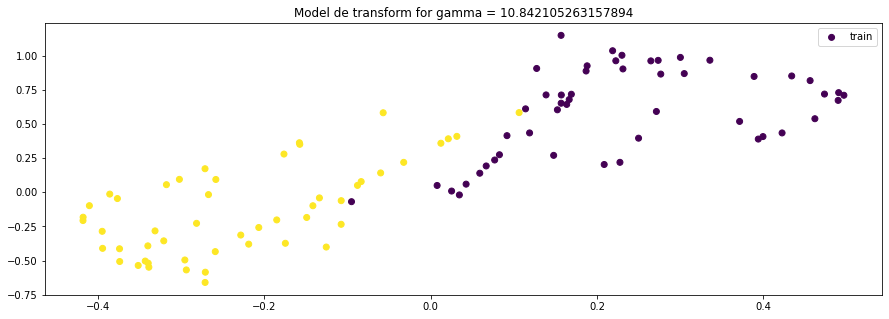

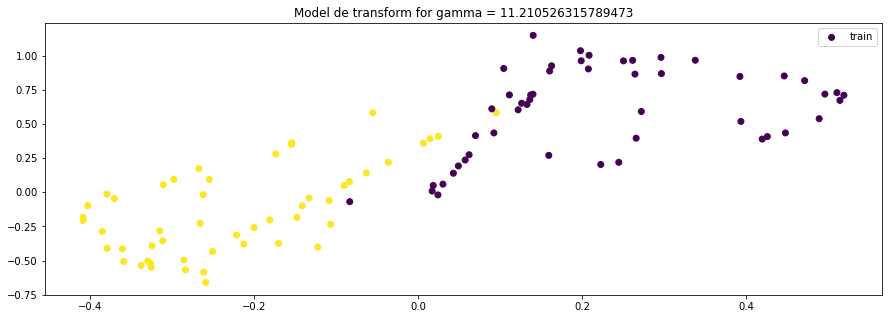

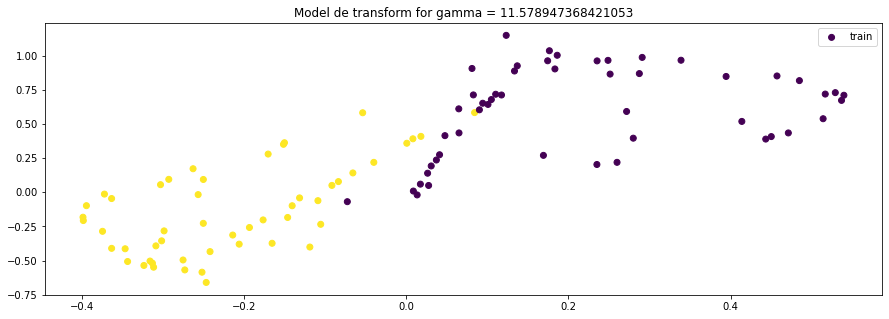

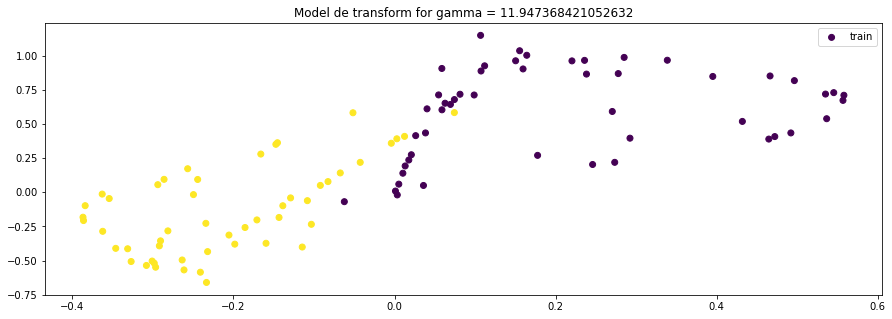

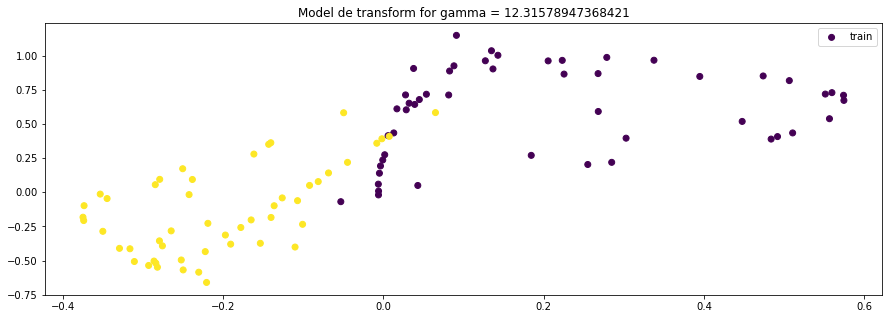

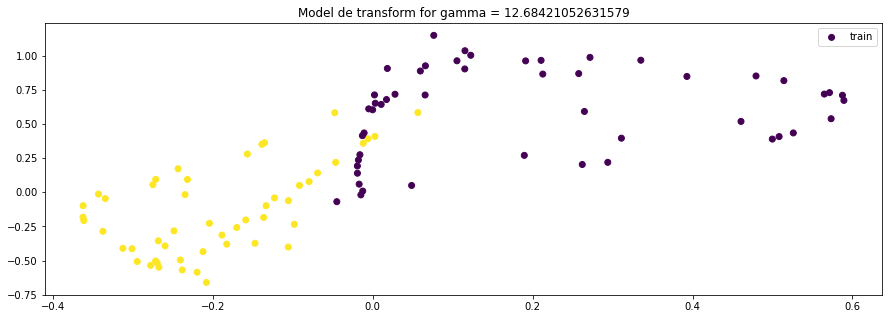

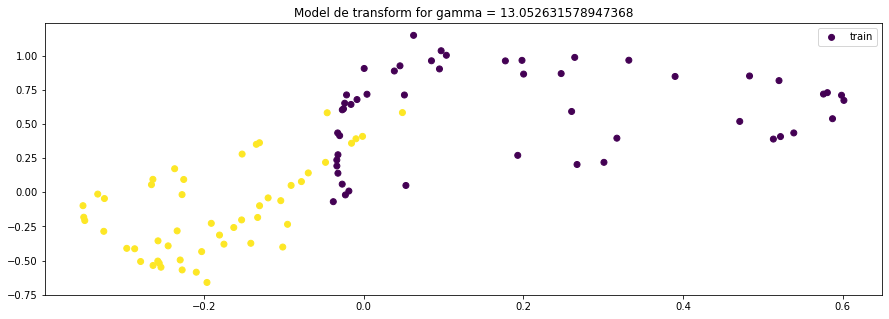

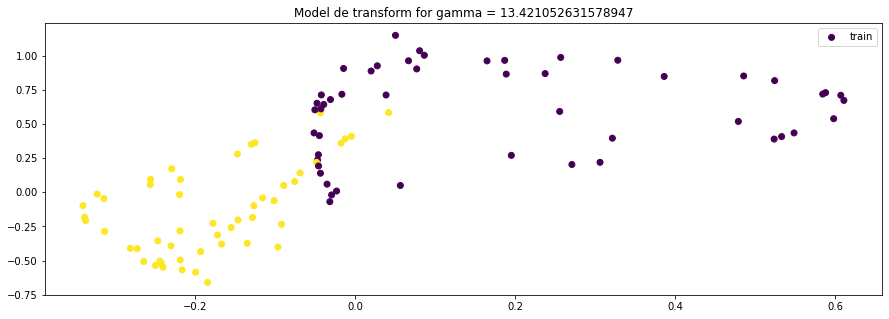

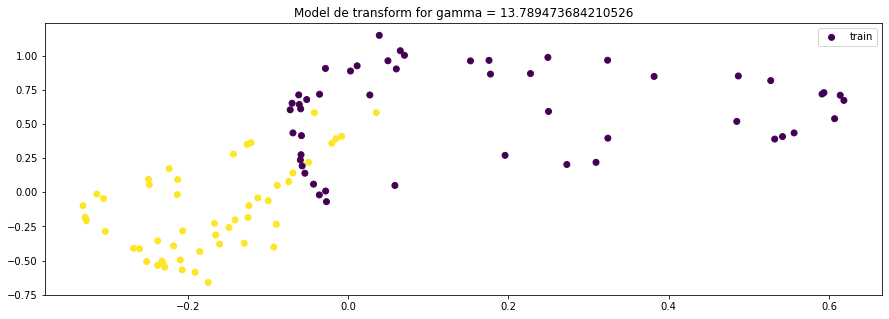

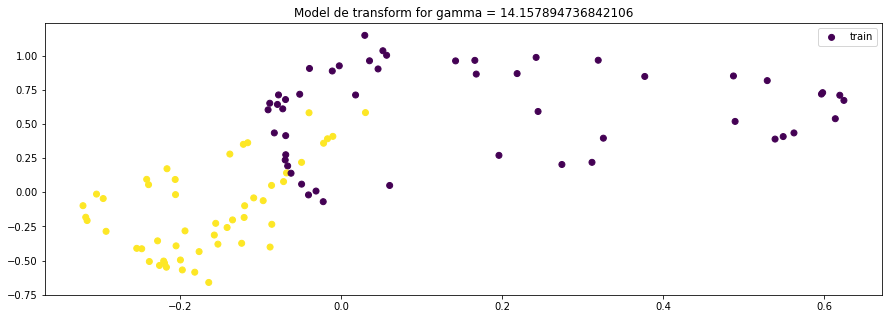

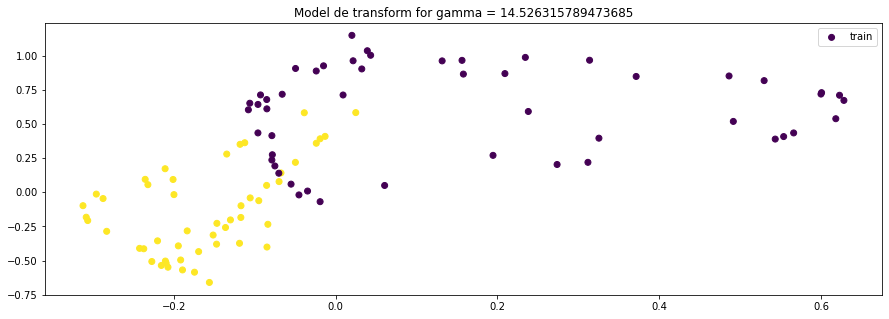

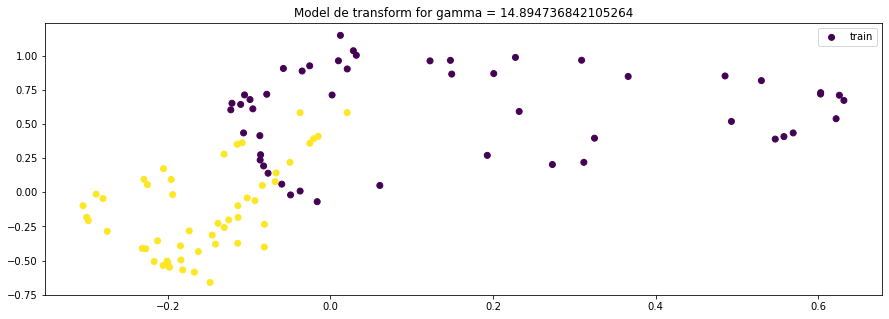

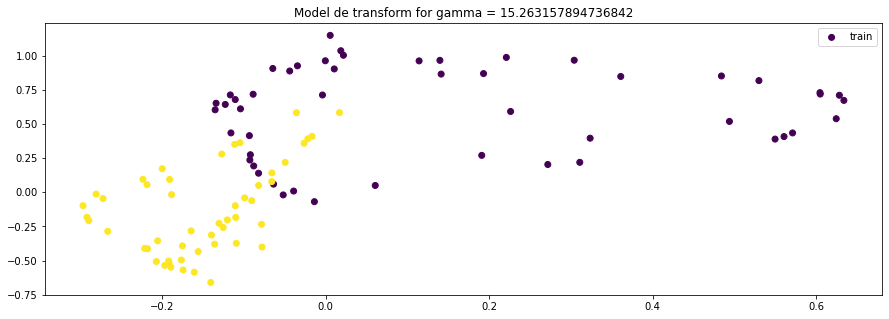

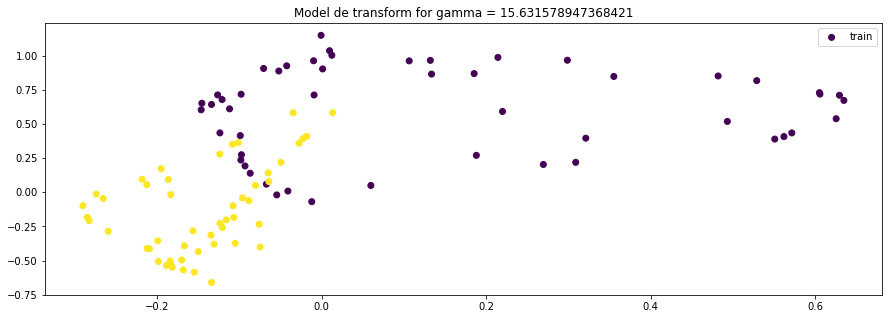

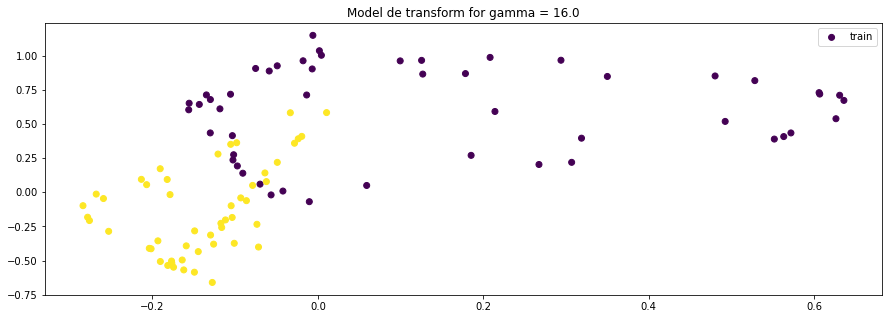

In [9]:
gammas = [0.01, 0.5, 1, 2, 9,10,11,12, 20]# np.linspace(0.1,5,20)
gammas = np.linspace(9,16, 20)
for g in gammas: 
    model_rbf = KPCA(n_components=n_components, kernel='rbf', gamma= g)
    
    #model_rbf = KernelPCA(n_components=n_components, kernel='rbf', gamma= g)
    model_rbf.fit(X)
    muestraSimple(model_rbf.transform(X), X[:,1],y,f'Model de transform for gamma = {g}')

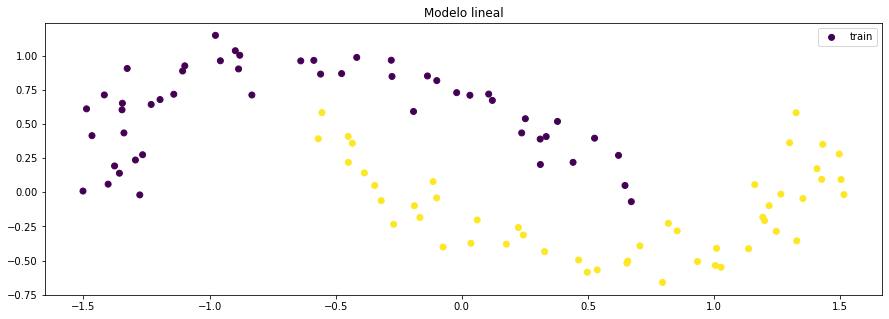

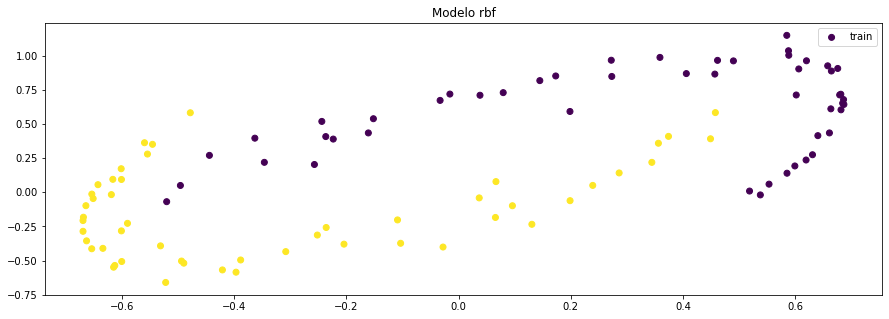

In [10]:
gamma = 12 # Valor sacado con el de sklearn

n_components=1

model_linear = KPCA(n_components=n_components, kernel='linear')
model_rbf = KPCA(n_components=n_components, kernel='rbf')

# Training of the models (complete).
model_linear.fit(X)
model_rbf.fit(X)

# Comparative of the projections (complete).
muestraSimple(model_linear.transform(X), X[:,1],y,'Modelo lineal')
muestraSimple(model_rbf.transform(X), X[:,1],y,'Modelo rbf')